In [11]:
import sys

# setting path
sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from utils import load_problem_data

In [12]:
DEMAND, DATACENTERS, SERVERS, SELLING_PRICES = load_problem_data('../data')

In [2]:
def calculate_moving_average(demand_df, window_size):
    # Group by server_generation
    grouped = demand_df.groupby('server_generation')
    
    # Function to calculate moving average for a group
    def group_moving_average(group):
        for col in ['high', 'low', 'medium']:
            group[col] = group[col].rolling(window=window_size, min_periods=1).mean().round().astype(int)
        return group
    
    # Apply moving average calculation to each group
    return grouped.apply(group_moving_average).reset_index(drop=True)

In [3]:
actual_demand = pd.read_csv('../data/test_data/actual_demand_1741.csv')

In [4]:
ma_v1 = calculate_moving_average(actual_demand, 27)

/var/folders/zf/pwcfbfvd57xc3klm5j_db50w0000gn/T/ipykernel_82180/206360383.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return grouped.apply(group_moving_average).reset_index(drop=True)


In [5]:
def calculate_sad_for_ma_windows(demand_df):
    def calculate_sad(original, ma):
        return np.sum(np.abs(original - ma))

    window_sizes = range(1, 121)  # 1 to 168
    sad_values = []

    for window_size in window_sizes:
        ma_df = calculate_moving_average(demand_df, window_size)
        sad = sum(calculate_sad(demand_df[col], ma_df[col]) for col in ['high', 'low', 'medium'])
        sad_values.append(sad)

    # Plotting    
    plt.figure(figsize=(25, 10))
    plt.plot(window_sizes, sad_values, color='blue', alpha=0.7, linewidth=1)
    plt.scatter(window_sizes, sad_values, color='red', s=20, alpha=0.7)
    plt.title('Sum of Absolute Differences (SAD) vs Moving Average Window Size')
    plt.xlabel('Moving Average Window Size')
    plt.ylabel('Sum of Absolute Differences')
    plt.grid(True)
    
    # Set x-axis ticks for every window size
    plt.xticks(range(1, 121, 1))
    plt.tick_params(axis='x', rotation=90)
    
    plt.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    plt.show()

    return sad_values

/var/folders/zf/pwcfbfvd57xc3klm5j_db50w0000gn/T/ipykernel_82180/206360383.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return grouped.apply(group_moving_average).reset_index(drop=True)
/var/folders/zf/pwcfbfvd57xc3klm5j_db50w0000gn/T/ipykernel_82180/206360383.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return grouped.apply(group_moving_average).reset_index(drop=True)
/var/folders/zf/pwcfbf

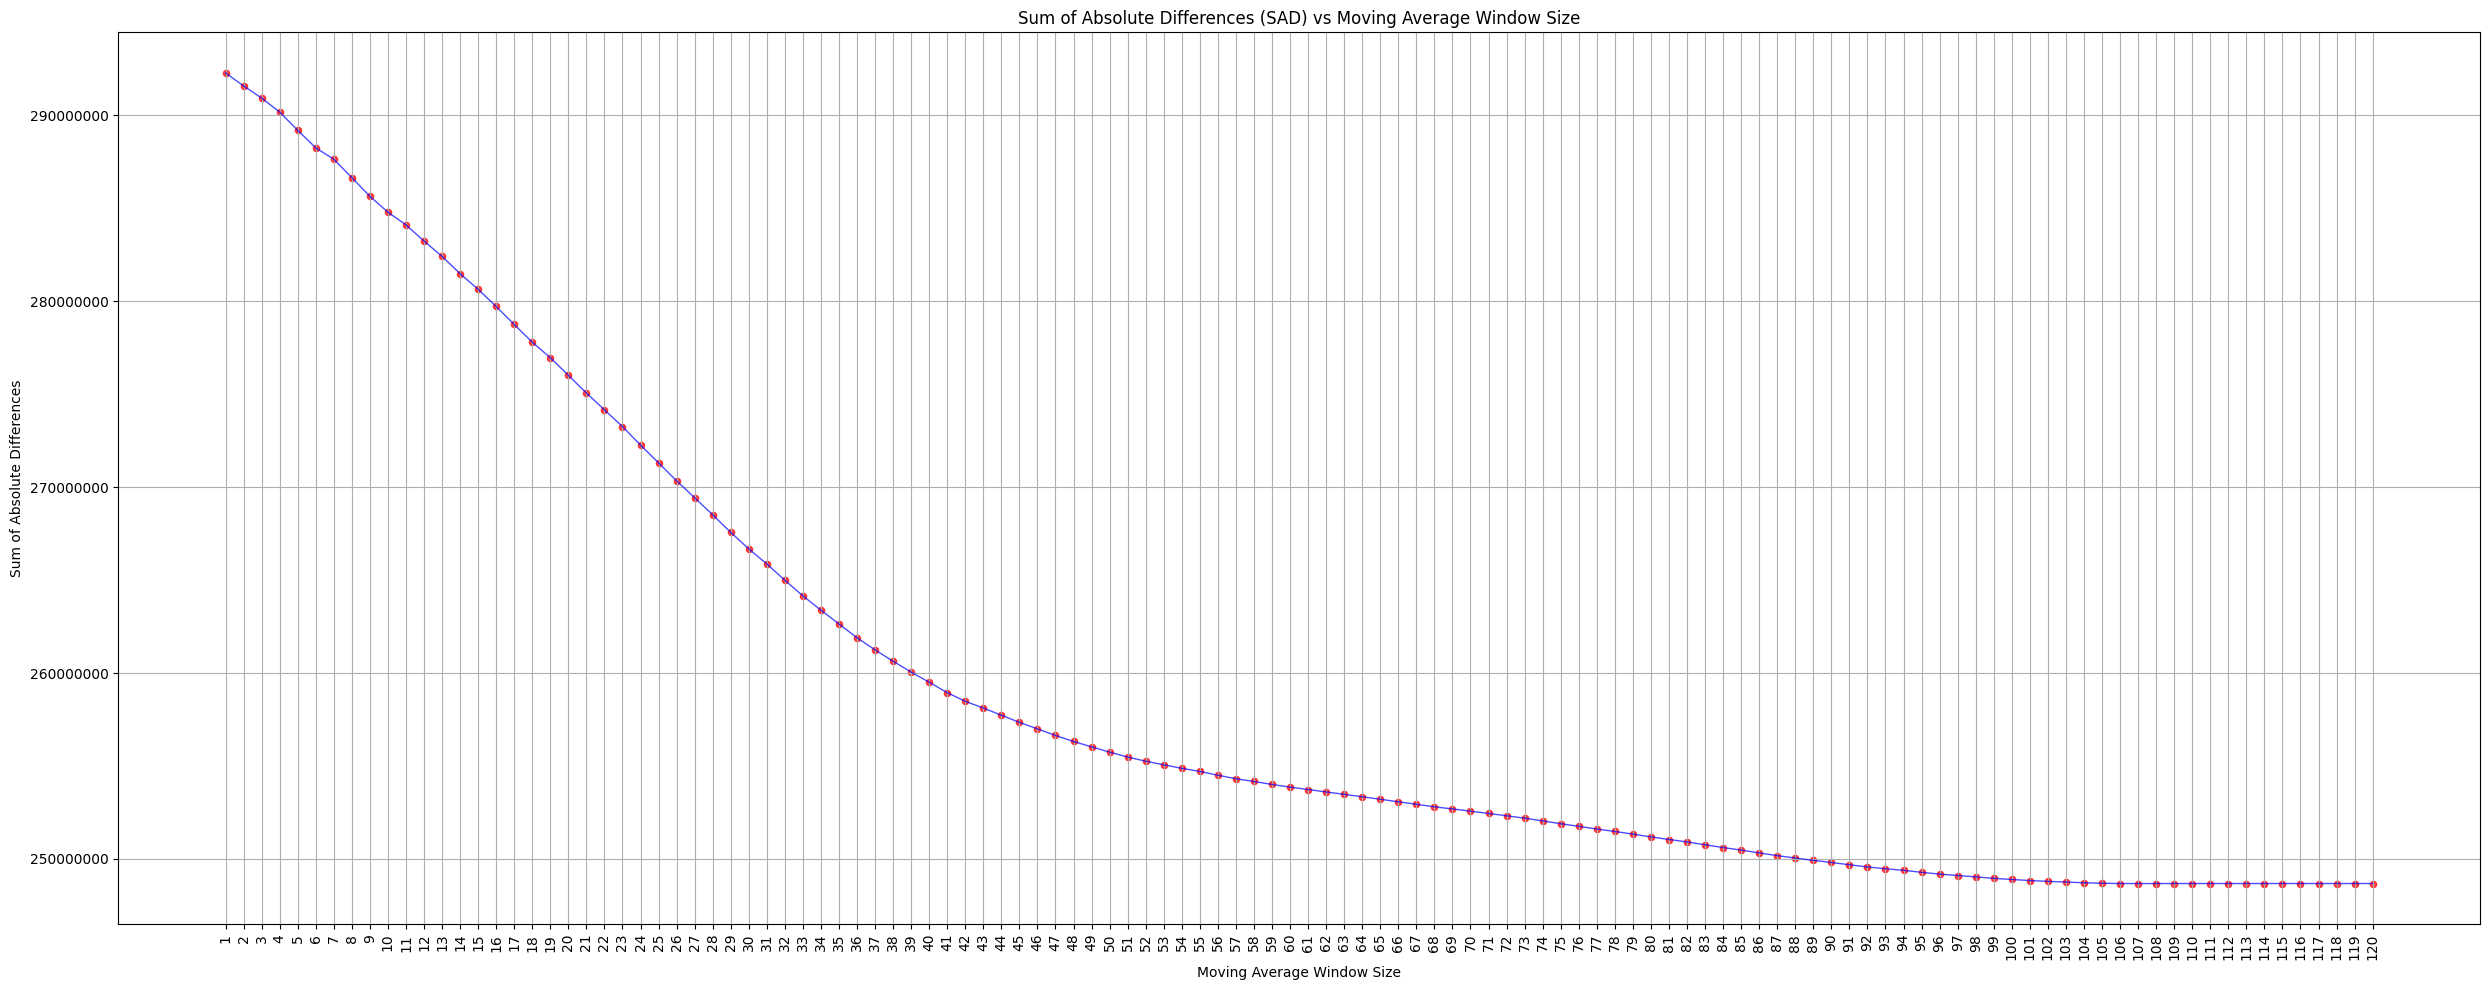

In [6]:
sad_ma = calculate_sad_for_ma_windows(actual_demand)

### Optimal MA Window Size is the lowest number at the curve smoothes out
### Starting 121 the MA is the SAD stops changing

In [53]:
def get_maintenance_cost(b, x, xhat):
    # CALCULATE THE CURRENT MAINTENANCE COST
    return b * (1 + (((1.5)*(x))/xhat * np.log2(((1.5)*(x))/xhat)))

In [57]:
for _, server in SERVERS.iterrows():
    for latency in ['high', 'medium', 'low']:
        sell_pr = SELLING_PRICES[(SELLING_PRICES['server_generation'] == server['server_generation']) & (SELLING_PRICES['latency_sensitivity'] == latency)]['selling_price'].iloc[0]

        print(f'{server['server_generation']} in latency: {latency}')
        for age in range(1, 97):
            b = server['average_maintenance_fee']
            x = age
            xhat = 96

            prof = server['capacity'] * sell_pr * x
            maintenance_cost = get_maintenance_cost(b, x, xhat)

            if maintenance_cost >= prof:
                print(f'age: {age}, maintenance cost: {maintenance_cost}')
                

CPU.S1 in latency: high
CPU.S1 in latency: medium
CPU.S1 in latency: low
CPU.S2 in latency: high
CPU.S2 in latency: medium
CPU.S2 in latency: low
CPU.S3 in latency: high
CPU.S3 in latency: medium
CPU.S3 in latency: low
CPU.S4 in latency: high
CPU.S4 in latency: medium
CPU.S4 in latency: low
GPU.S1 in latency: high
GPU.S1 in latency: medium
GPU.S1 in latency: low
GPU.S2 in latency: high
GPU.S2 in latency: medium
GPU.S2 in latency: low
GPU.S3 in latency: high
GPU.S3 in latency: medium
GPU.S3 in latency: low


In [31]:
obj = pd.read_json('../data/test_data/solution_w2_analysis.json')

In [35]:
print(obj['U'].mean())

0.810952380952381
